In [ ]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 60.6 MB/s eta 0:00:00


Circuit diagram:
(0, 0): ───H───────@───H───X───────────@───X───H───────────@───H───X───────────@───X───H───────M('result')───
                   │                   │                   │                   │               │
(0, 1): ───H───X───@───X───H───X───────@───X───H───X───────@───X───H───X───────@───X───H───────M─────────────
                   │                   │                   │                   │               │
(0, 2): ───H───H───X───H───H───X───H───X───H───X───H───H───X───H───H───X───H───X───H───X───H───M─────────────
Measurement results for target |101>:
State |000>: 16 times (1.60%) 
State |001>: 4 times (0.40%) 
State |010>: 6 times (0.60%) 
State |011>: 3 times (0.30%) 
State |100>: 5 times (0.50%) 
State |101>: 951 times (95.10%) <-- Target
State |110>: 4 times (0.40%) 
State |111>: 11 times (1.10%) 

Success rate: 95.10% (optimal ~94% after 2 iterations)


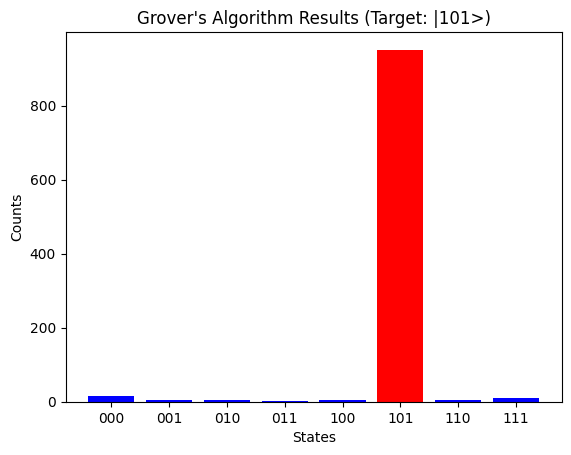

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

def grover_3_qubit(target_binary):
    qubits = [cirq.GridQubit(0, i) for i in range(3)]
    circuit = cirq.Circuit()

    # Initialize superposition
    circuit.append(cirq.H.on_each(*qubits))
    # Removed: circuit.append(cirq.Barrier(*qubits))  # Barrier after initialization

    # Number of Grover iterations
    N = 2 ** 3
    iterations = int(np.floor(np.pi/4 * np.sqrt(N)))

    for iteration in range(iterations):
        # Oracle
        apply_oracle(circuit, qubits, target_binary)
        # Removed: circuit.append(cirq.Barrier(*qubits))  # Barrier after oracle

        # Diffusion
        apply_diffusion(circuit, qubits)
        # Removed: circuit.append(cirq.Barrier(*qubits))  # Barrier after diffusion

    # Measurement
    circuit.append(cirq.measure(*qubits, key='result'))

    return circuit, qubits

def apply_oracle(circuit, qubits, target_binary):
    # Apply X gates where target bit is 0
    for i, bit in enumerate(target_binary):
        if bit == '0':
            circuit.append(cirq.X(qubits[i]))

    # Multi-controlled Z using H and CCX
    circuit.append(cirq.H(qubits[-1]))
    circuit.append(cirq.CCX(qubits[0], qubits[1], qubits[2]))
    circuit.append(cirq.H(qubits[-1]))

    # Undo X gates
    for i, bit in enumerate(target_binary):
        if bit == '0':
            circuit.append(cirq.X(qubits[i]))

def apply_diffusion(circuit, qubits):
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H(qubits[-1]))
    circuit.append(cirq.CCX(qubits[0], qubits[1], qubits[2]))
    circuit.append(cirq.H(qubits[-1]))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))

def analyze_results(counts, target):
    total = sum(counts.values())
    success = counts.get(int(target, 2), 0)
    success_rate = success / total * 100

    print(f"Measurement results for target |{target}>:")
    for state in range(8):
        bitstr = format(state, '03b')
        count = counts.get(state, 0)
        pct = count / total * 100
        marker = "<-- Target" if bitstr == target else ""
        print(f"State |{bitstr}>: {count} times ({pct:.2f}%) {marker}")

    print(f"\nSuccess rate: {success_rate:.2f}% (optimal ~94% after 2 iterations)")

    states = [format(i, '03b') for i in range(8)]
    values = [counts.get(i, 0) for i in range(8)]
    colors = ['red' if s == target else 'blue' for s in states]

    plt.bar(states, values, color=colors)
    plt.title(f"Grover's Algorithm Results (Target: |{target}>)")
    plt.xlabel("States")
    plt.ylabel("Counts")
    plt.show()

if __name__ == "__main__":
    target = "101"
    circuit, qubits = grover_3_qubit(target)

    print("Circuit diagram:")
    print(circuit)

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)
counts = result.histogram(key='result')
analyze_results(counts, target)